In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
import math
import numba
import numpy
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from google.colab import files

In [ ]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tqdm import tqdm


class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

In [ ]:
count_data = 11
inputs_1 = list()
inputs_2 = list()
masks = list()

for i in range(count_data):
  inputs_1.append(Image.open("/content/drive/MyDrive/input/input_1/input_{}.png".format(i+1)).convert("RGB"))
  inputs_2.append(Image.open("/content/drive/MyDrive/input/input_2/input_{}.png".format(i+1)).convert("RGB"))
  masks.append(Image.open("/content/drive/MyDrive/input/mask/mask_{}.png".format(i+1)))

input_ds = list()
mask_ds = list()

for data in range(count_data):
  for x in range(inputs_1[data].size[0]):
      for y in range(inputs_1[data].size[1]):
          mask_ds.append((masks[data].getpixel((x,y))[0] / 255, masks[data].getpixel((x,y))[1] / 255, masks[data].getpixel((x,y))[2] / 255))
          inp = np.zeros(486)
          index = 0
          for i in range(-4, 5):
              for j in range(-4, 5):
                for k in range(3):
                  if not(0 <= (x + i) < inputs_1[data].size[0]) or not(0 <= (y + j) < inputs_1[data].size[1]):
                      inp[index] = 0
                      inp[243 + index] = 0
                  else:
                      inp[index] = inputs_1[data].getpixel((x+i, y+j))[k] / 255
                      inp[243 + index] = inputs_2[data].getpixel((x+i, y+j))[k] / 255
                  index += 1
          input_ds.append(inp)

input_ds = np.array(input_ds)
mask_ds = np.array(mask_ds)

KeyboardInterrupt: ignored

Задаем функцию создания нейронной сети


In [ ]:
model = Sequential()
activation_choice = 'elu'
model.add(Dense(486,activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(units=720,
                activation=activation_choice))
model.add(Dense(3, activation='sigmoid'))
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy'])

Создаем tuner

Доступные типы тюнеров:

    RandomSearch - случайный поиск.
    Hyperband - алгоритм оптимизации на основе многорукого бандита, Li, Lisha, and Kevin Jamieson. "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."Journal of Machine Learning Research 18 (2018): 1-52.
    BayesianOptimization - байесовская оптимизация.



In [ ]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from google.colab import files

<ipython-input-7-225f8a95a6f9>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


In [ ]:
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=40,               # максимальное количество запусков обучения
    directory='test_directory'   # каталог, куда сохраняются обученные сети
    )

Запускаем подбор гиперпараметров

Пространство поиска


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 600, 'step': 32, 'sampling': 'linear'}


Подбор гиперпараметров

In [ ]:
tuner.search(input_ds,                  # Данные для обучения
             mask_ds,                  # Правильные ответы
             batch_size=256,           # Размер мини-выборки
             epochs=10,                # Количество эпох обучения
             validation_split=0.125,     # Часть данных, которая будет использоваться для проверки
             )

Trial 13 Complete [00h 13m 25s]
val_accuracy: 0.48325613141059875

Best val_accuracy So Far: 0.5020174384117126
Total elapsed time: 02h 33m 50s


Выбираем лучшую модель


In [ ]:
tuner.results_summary()

Results summary
Results in test_directory/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_hidden: 480
Score: 0.5020174384117126
Trial summary
Hyperparameters:
units_hidden: 448
Score: 0.49317842721939087
Trial summary
Hyperparameters:
units_hidden: 512
Score: 0.48897087574005127
Trial summary
Hyperparameters:
units_hidden: 352
Score: 0.4886254668235779
Trial summary
Hyperparameters:
units_hidden: 544
Score: 0.4868828058242798
Trial summary
Hyperparameters:
units_hidden: 416
Score: 0.4861292243003845
Trial summary
Hyperparameters:
units_hidden: 384
Score: 0.48325613141059875
Trial summary
Hyperparameters:
units_hidden: 320
Score: 0.4720935821533203
Trial summary
Hyperparameters:
units_hidden: 256
Score: 0.4703351855278015
Trial summary
Hyperparameters:
units_hidden: 288
Score: 0.469173401594162


Получаем три лучших модели

In [ ]:
models = tuner.get_best_models(num_models=3)

NameError: ignored

In [ ]:
history = model.fit(input_ds,  mask_ds,batch_size = 256, epochs=40, validation_split=0.2)

Epoch 1/40
1593/1593 [==============================] - 236s 147ms/step - loss: 0.3002 - accuracy: 0.4681 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 2/40
1593/1593 [==============================] - 234s 147ms/step - loss: 0.3003 - accuracy: 0.4683 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 3/40
1593/1593 [==============================] - 230s 144ms/step - loss: 0.3003 - accuracy: 0.4683 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 4/40
1593/1593 [==============================] - 230s 145ms/step - loss: 0.3003 - accuracy: 0.4683 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 5/40
1593/1593 [==============================] - 234s 147ms/step - loss: 0.3003 - accuracy: 0.4683 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 6/40
1593/1593 [==============================] - 229s 144ms/step - loss: 0.3003 - accuracy: 0.4683 - val_loss: 0.3447 - val_accuracy: 0.3080
Epoch 7/40
1593/1593 [==============================] - 231s 145ms/step - loss: 0.3003 - accuracy: 0.4683 - val_

KeyboardInterrupt: ignored

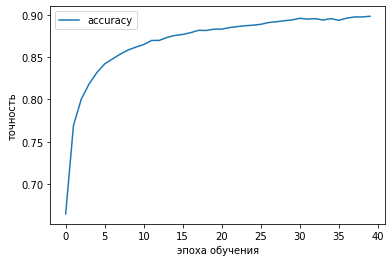

In [ ]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.xlabel('эпоха обучения')
plt.ylabel('точность')
plt.legend()
plt.show()

In [ ]:
model.save('model_5х5.h5')

In [ ]:
id = 0
img : np.ndarray
img = model.predict(input_ds[:inputs_1[id].size[0]*inputs_1[id].size[1]]) * 255
img = img.reshape((inputs_1[id].size[0],inputs_1[id].size[1],3))
img = img.astype(np.uint8)
Image.fromarray(img)

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/model_7х7.h5')

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import os

In [ ]:
based_dir = '/content/drive/MyDrive/Для Димы/'
grain_list = os.listdir(based_dir)

In [ ]:
for grain in grain_list:
  max_x = 0
  max_y = 0
  for i in range(4):
    x_value, y_value = Image.open(based_dir+grain+'/'+str(90*i)+'.tif').convert("RGB").size
    print(str(x_value)+'    '+str(y_value))

4445    4998
6063    6027
5209    5053
4425    4854
4063    3414
4042    3490
4063    3332
4069    3518
4500    4370
5353    4500
4090    4343
4151    4363
4554    4643
4643    4554
4172    4561
4206    4472
4418    4780
4780    4772
4445    4807
4807    4881
4390    4916
4916    4827
4418    4807
4506    4936
4254    4725
4725    4554
4309    4506
4370    4527
4500    4588
4588    4527
4200    4506
4370    4581


In [ ]:
grain = grain_list[0]
jj = 2
kk = 3

In [ ]:
plastin = list()
plastin.append(Image.open(based_dir+grain+'/'+str(90*jj)+'.tif').convert("RGB").resize((1000, 1000)))
plastin.append(Image.open(based_dir+grain+'/'+str(90*kk)+'.tif').convert("RGB").resize((1000, 1000)))
plastin_ds = list()
for x in range(plastin[0].size[0]):
    for y in range(plastin[0].size[1]):
        inp = np.zeros(294)
        index = 0
        for i in range(-3, 4):
            for j in range(-3, 4):
              for k in range(3):
                if not(0 <= (x + i) < plastin[0].size[0]) or not(0 <= (y + j) < plastin[0].size[1]):
                    inp[index] = 0
                    inp[147 + index] = 0
                else:
                    inp[index] = plastin[0].getpixel((x+i, y+j))[k] / 255
                    inp[147 + index] = plastin[1].getpixel((x+i, y+j))[k] / 255
                index += 1
        plastin_ds.append(inp)

plastin_ds = np.array(plastin_ds)
out = (model.predict(plastin_ds)* 255).astype(np.uint8)
Image.fromarray(out.reshape(plastin[0].size[0], plastin[0].size[1], 3)).save(grain+' '+str(90*jj)+'-'+str(kk*90)+'.png')
files.download(grain+' '+str(90*jj)+'-'+str(kk*90)+'.png')

31250/31250 [==============================] - 195s 6ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>